In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [18]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [19]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=2000 # length of data set
P=500 # range to fit acf

In [20]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

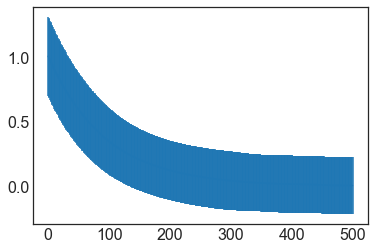

In [21]:
plt.errorbar(t,acf_mean,yerr=acf_std)

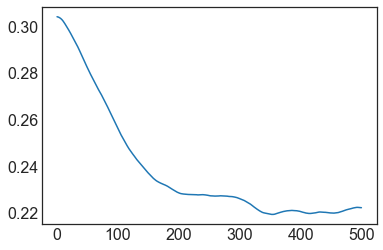

In [22]:
plt.plot(t,acf_std)

In [23]:
acf_all[0].size

500

In [25]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[1,1],
                            out.values['amplitude'],
                            out.covar[0,0],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        

    if result_array is None:
        result_array = fit_results
    else:
        result_array = np.vstack((result_array, fit_results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.64439350
    reduced chi-square = 0.00932609
    Akaike info crit   = -2335.47365
    Bayesian info crit = -2327.04444
[[Variables]]
    decay:      36.9407220 +/- 1.91738410 (5.19%) (init = 100)
    amplitude:  0.85429037 +/- 0.03093783 (3.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.697

***** Iteration  1  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 8.75045310
    reduced chi-square = 0.01757119
    Akaike info crit   = -2018.75131
    Bayesian info crit = -2010.32209
[[Variables]]
    decay:      66.7927185 +/- 2.27822878 (3.41%) (init = 100)
    amplitude:

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 9.72456053
    reduced chi-square = 0.01952723
    Akaike info crit   = -1965.97670
    Bayesian info crit = -1957.54748
[[Variables]]
    decay:      55.2467315 +/- 2.35539681 (4.26%) (init = 100)
    amplitude:  1.23640328 +/- 0.03692689 (2.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  54  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.25927132
    reduced chi-square = 0.00453669
    Akaike info crit   = -2695.78288
    Bayesian info crit = -2687.35366
[[Variables]]
    decay:      70.4739065 +/- 2.10102904 (2.98%) (init = 100)
    amplitude:  0.75582954 +/- 0.015822

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.36003699
    reduced chi-square = 0.00473903
    Akaike info crit   = -2673.96540
    Bayesian info crit = -2665.53619
[[Variables]]
    decay:      150.169592 +/- 4.45609852 (2.97%) (init = 100)
    amplitude:  0.54987295 +/- 0.01128502 (2.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  109  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.37677748
    reduced chi-square = 0.00477265
    Akaike info crit   = -2670.43126
    Bayesian info crit = -2662.00205
[[Variables]]
    decay:      120.058335 +/- 3.02647609 (2.52%) (init = 100)
    amplitude:  0.71062888 +/- 0.01254

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 500
    # variables        = 2
    chi-square         = 1.98989703
    reduced chi-square = 0.00399578
    Akaike info crit   = -2759.26260
    Bayesian info crit = -2750.83339
[[Variables]]
    decay:      23.4366306 +/- 1.45791902 (6.22%) (init = 100)
    amplitude:  0.58164151 +/- 0.02503505 (4.30%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.692

***** Iteration  166  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 500
    # variables        = 2
    chi-square         = 6.13437735
    reduced chi-square = 0.01231803
    Akaike info crit   = -2196.34976
    Bayesian info crit = -2187.92054
[[Variables]]
    decay:      189.791923 +/- 8.73301574 (4.60%) (init = 100)
    amplitude:  0.53520273 +/- 0.01648

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 3.22751214
    reduced chi-square = 0.00648095
    Akaike info crit   = -2517.44825
    Bayesian info crit = -2509.01903
[[Variables]]
    decay:      133.919397 +/- 2.17614077 (1.62%) (init = 100)
    amplitude:  1.22649181 +/- 0.01389605 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  222  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.92912687
    reduced chi-square = 0.00989785
    Akaike info crit   = -2305.72312
    Bayesian info crit = -2297.29390
[[Variables]]
    decay:      226.808367 +/- 4.27385648 (1.88%) (init = 100)
    amplitude:  1.14362054 +/- 0.01381

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 500
    # variables        = 2
    chi-square         = 4.72153505
    reduced chi-square = 0.00948099
    Akaike info crit   = -2327.23707
    Bayesian info crit = -2318.80785
[[Variables]]
    decay:      44.2282097 +/- 2.05565484 (4.65%) (init = 100)
    amplitude:  0.88131035 +/- 0.02862982 (3.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.699

***** Iteration  276  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 500
    # variables        = 2
    chi-square         = 20.7628800
    reduced chi-square = 0.04169253
    Akaike info crit   = -1586.72066
    Bayesian info crit = -1578.29144
[[Variables]]
    decay:      66.0988438 +/- 3.72155835 (5.63%) (init = 100)
    amplitude:  1.25192484 +/- 0.04948

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 5.15076779
    reduced chi-square = 0.01034291
    Akaike info crit   = -2283.73116
    Bayesian info crit = -2275.30194
[[Variables]]
    decay:      60.3921421 +/- 3.25726648 (5.39%) (init = 100)
    amplitude:  0.68085843 +/- 0.02574352 (3.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  322  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 6.35843914
    reduced chi-square = 0.01276795
    Akaike info crit   = -2178.41258
    Bayesian info crit = -2169.98337
[[Variables]]
    decay:      191.128879 +/- 2.72502491 (1.43%) (init = 100)
    amplitude:  1.75662203 +/- 0.01673

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 500
    # variables        = 2
    chi-square         = 8.88195630
    reduced chi-square = 0.01783525
    Akaike info crit   = -2011.29313
    Bayesian info crit = -2002.86391
[[Variables]]
    decay:      63.0608877 +/- 2.68619151 (4.26%) (init = 100)
    amplitude:  1.10763554 +/- 0.03311250 (2.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  373  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 1.97011355
    reduced chi-square = 0.00395605
    Akaike info crit   = -2764.25846
    Bayesian info crit = -2755.82924
[[Variables]]
    decay:      43.8274419 +/- 1.18847088 (2.71%) (init = 100)
    amplitude:  0.97968923 +/- 0.01857

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.60214916
    reduced chi-square = 0.00522520
    Akaike info crit   = -2625.13520
    Bayesian info crit = -2616.70598
[[Variables]]
    decay:      76.4269361 +/- 1.39675124 (1.83%) (init = 100)
    amplitude:  1.27168870 +/- 0.01632385 (1.28%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  427  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 48.3020883
    reduced chi-square = 0.09699215
    Akaike info crit   = -1164.56665
    Bayesian info crit = -1156.13744
[[Variables]]
    decay:      54.8113111 +/- 4.87016371 (8.89%) (init = 100)
    amplitude:  1.32694744 +/- 0.08262

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 21.8690969
    reduced chi-square = 0.04391385
    Akaike info crit   = -1560.76678
    Bayesian info crit = -1552.33756
[[Variables]]
    decay:      78.8964669 +/- 4.43221169 (5.62%) (init = 100)
    amplitude:  1.18053262 +/- 0.04660089 (3.95%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  484  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 12.8168493
    reduced chi-square = 0.02573665
    Akaike info crit   = -1827.92372
    Bayesian info crit = -1819.49451
[[Variables]]
    decay:      263.449336 +/- 6.76015922 (2.57%) (init = 100)
    amplitude:  1.35230255 +/- 0.02116

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 12.2405507
    reduced chi-square = 0.02457942
    Akaike info crit   = -1850.92691
    Bayesian info crit = -1842.49770
[[Variables]]
    decay:      110.711406 +/- 4.08131722 (3.69%) (init = 100)
    amplitude:  1.14390916 +/- 0.02958903 (2.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  536  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 4.20013089
    reduced chi-square = 0.00843400
    Akaike info crit   = -2385.74620
    Bayesian info crit = -2377.31699
[[Variables]]
    decay:      147.580762 +/- 3.38586952 (2.29%) (init = 100)
    amplitude:  0.95476192 +/- 0.01517

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 8.19238052
    reduced chi-square = 0.01645056
    Akaike info crit   = -2051.70179
    Bayesian info crit = -2043.27257
[[Variables]]
    decay:      66.1805460 +/- 4.14616320 (6.26%) (init = 100)
    amplitude:  0.70625957 +/- 0.03106615 (4.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

***** Iteration  591  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 4.08207644
    reduced chi-square = 0.00819694
    Akaike info crit   = -2400.00115
    Bayesian info crit = -2391.57194
[[Variables]]
    decay:      80.5987064 +/- 1.79327045 (2.22%) (init = 100)
    amplitude:  1.27467673 +/- 0.01992

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.45074011
    reduced chi-square = 0.00291313
    Akaike info crit   = -2917.26713
    Bayesian info crit = -2908.83791
[[Variables]]
    decay:      103.362374 +/- 1.56665795 (1.52%) (init = 100)
    amplitude:  0.98893942 +/- 0.01052797 (1.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  645  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 500
    # variables        = 2
    chi-square         = 16.3534375
    reduced chi-square = 0.03283823
    Akaike info crit   = -1706.08499
    Bayesian info crit = -1697.65577
[[Variables]]
    decay:      71.8152547 +/- 3.41890410 (4.76%) (init = 100)
    amplitude:  1.26138877 +/- 0.04218

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 38.0374362
    reduced chi-square = 0.07638039
    Akaike info crit   = -1284.01863
    Bayesian info crit = -1275.58941
[[Variables]]
    decay:      81.3179050 +/- 6.86989302 (8.45%) (init = 100)
    amplitude:  1.02000370 +/- 0.06056812 (5.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  699  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.97769221
    reduced chi-square = 0.00397127
    Akaike info crit   = -2762.33874
    Bayesian info crit = -2753.90953
[[Variables]]
    decay:      72.6087023 +/- 1.65254623 (2.28%) (init = 100)
    amplitude:  0.91285738 +/- 0.01459

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 4.61974257
    reduced chi-square = 0.00927659
    Akaike info crit   = -2338.13456
    Bayesian info crit = -2329.70534
[[Variables]]
    decay:      66.9989011 +/- 2.11984394 (3.16%) (init = 100)
    amplitude:  1.04427160 +/- 0.02318617 (2.22%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

***** Iteration  754  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.57941748
    reduced chi-square = 0.00116349
    Akaike info crit   = -3376.17006
    Bayesian info crit = -3367.74085
[[Variables]]
    decay:      30.2131219 +/- 0.86410382 (2.86%) (init = 100)
    amplitude:  0.60370212 +/- 0.01201

***** Iteration  805  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.12061047
    reduced chi-square = 0.00225022
    Akaike info crit   = -3046.36725
    Bayesian info crit = -3037.93803
[[Variables]]
    decay:      270.086045 +/- 3.52806061 (1.31%) (init = 100)
    amplitude:  0.78680942 +/- 0.00620780 (0.79%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.747

***** Iteration  806  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.73131870
    reduced chi-square = 0.00146851
    Akaike info crit   = -3259.75702
    Bayesian info crit = -3251.32780
[[Variables]]
    decay:      304.055964 +/- 6.75800064 (2.22%) (init = 100)
    amplit

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 500
    # variables        = 2
    chi-square         = 20.2616894
    reduced chi-square = 0.04068612
    Akaike info crit   = -1598.93811
    Bayesian info crit = -1590.50889
[[Variables]]
    decay:      54.3122310 +/- 2.97196531 (5.47%) (init = 100)
    amplitude:  1.40173171 +/- 0.05375222 (3.83%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  860  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.15369401
    reduced chi-square = 0.00432469
    Akaike info crit   = -2719.71179
    Bayesian info crit = -2711.28258
[[Variables]]
    decay:      50.1808984 +/- 2.03036553 (4.05%) (init = 100)
    amplitude:  0.64242230 +/- 0.01820

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.36091128
    reduced chi-square = 0.00273275
    Akaike info crit   = -2949.22678
    Bayesian info crit = -2940.79757
[[Variables]]
    decay:      51.8474668 +/- 1.43784245 (2.77%) (init = 100)
    amplitude:  0.73334959 +/- 0.01424488 (1.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.700

***** Iteration  914  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 10.0688300
    reduced chi-square = 0.02021853
    Akaike info crit   = -1948.58179
    Bayesian info crit = -1940.15258
[[Variables]]
    decay:      42.7536873 +/- 3.49574937 (8.18%) (init = 100)
    amplitude:  0.74332487 +/- 0.04250

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 3.60520857
    reduced chi-square = 0.00723937
    Akaike info crit   = -2462.11424
    Bayesian info crit = -2453.68502
[[Variables]]
    decay:      125.396288 +/- 3.84599150 (3.07%) (init = 100)
    amplitude:  0.70569434 +/- 0.01514181 (2.15%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

***** Iteration  968  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 9.33370858
    reduced chi-square = 0.01874239
    Akaike info crit   = -1986.48784
    Bayesian info crit = -1978.05862
[[Variables]]
    decay:      213.528221 +/- 7.10357920 (3.33%) (init = 100)
    amplitude:  0.89627597 +/- 0.01943

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


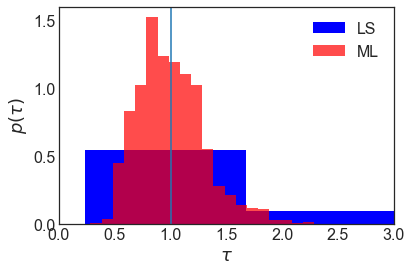

In [26]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [27]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t


In [28]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.3587749525271064
Decay time LS std (real): 1.8470844116716065
Decay time LS stderr (real): 0.04130206304677918
Decay time (mean-true)/stderr: 8.68661093565118
Decay time LS std (fit): 0.00025088932179522064
Decay time LS std (fit corrected): 0.0002516650250494578
Decay time Bayes mean (real): 1.0055027277847248
Decay time Bayes std (real): 0.3003203613051664
Decay time Bayes stderr (real): 0.006715367429056494
Decay time Bayes std (fit): 0.32205769501322445


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


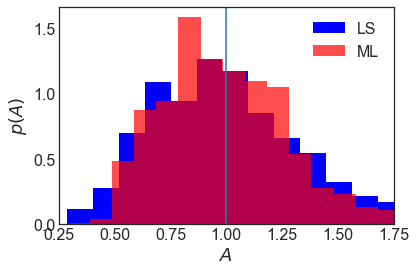

In [29]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [30]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 1.0147488012350934
Amplitude LS std (real): 0.35602047473214293
Amplitude LS stderr (real): 0.007960859828828179
Amplitude LS std (fit): 5.215044185979458
Amplitude LS std (fit corrected): 6.275785085502055
Amplitude Bayes mean (real): 1.0061291560273131
Amplitude Bayes std (real): 0.29926383821657704
Amplitude Bayes std (fit): 0.32052861403791433


(1000, 5)
(1000, 4)
(0.2463508260461941, 2.7301653983245087e-15)


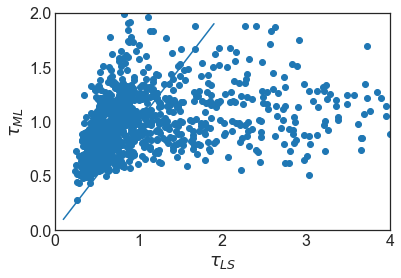

In [31]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8593502720211577, 6.316785360739052e-293)


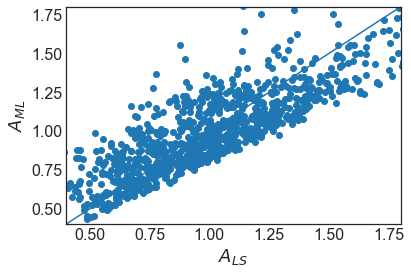

In [32]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],result_array.T[3],result_array.T[0],result_array.T[1]):
    print(i,a,da,t,dt)

In [ ]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
print(plt.style.available)